# Figure 3

This figure shows the emergent constraint for both temperature variability metrics in the paleomodel ensemble.

In [1]:
# import the necessary libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy import signal
from scipy import stats
from scipy.stats import linregress
from scipy.signal import detrend
import scipy.signal as signal
from statsmodels.api import tsa
import xarray as xr
import warnings
import zarr

# style guide for plots
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['font.size'] = 12

def compute_cox(x):
    x = x[~np.isnan(x)]
    psi_vals=[]
    for i in np.arange(0, len(x)-55):
        y = signal.detrend(x[i:i+55])
        auto_m1 = tsa.acf(y,nlags=1) # autocorrelation function from statsmodels
        auto_m1b = auto_m1[1]    # select 1 lag autocorrelation value
        sigma_m1= np.std(y)
        log_m1= np.log(auto_m1b)
        log_m1b = np.abs(log_m1)   # take absolute value
        sqrt_m1 = np.sqrt(log_m1b)
        psi = sigma_m1/sqrt_m1
        psi_vals.append(psi)
    return np.nanmean(psi_vals)

def compute_nijsse(x, length=10):
    # remove NaNs from the timeseries
    x = np.array(x)
    mask = ~np.isnan(x)
    x = x[mask]
    # fill it with slopes
    slopes = []
    i = 0
    while i < len(x)-length:
        slope, intercept, r, p, se = linregress(np.arange(0,length), x[i:i+length])
        slopes.append(length*slope)
        i+=length
    return np.nanstd(slopes)

In [2]:
from pathlib import Path
import os
notebooks_dir = Path(os.path.abspath('__file__')).parent.parent
data_dir = notebooks_dir.parent / 'data'

In [4]:
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

class HandlerTupleVertical(HandlerTuple):
    def __init__(self, **kwargs):
        HandlerTuple.__init__(self, **kwargs)

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # How many lines are there.
        numlines = len(orig_handle)
        handler_map = legend.get_legend_handler_map()

        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        height_y = (height / numlines)

        leglines = []
        for i, handle in enumerate(orig_handle):
            handler = legend.get_legend_handler(handler_map, handle)

            legline = handler.create_artists(legend, handle,
                                             xdescent,
                                             (2*i + 1)*height_y,
                                             width,
                                             2*height,
                                             fontsize, trans)
            leglines.extend(legline)

        return leglines

Cox: 1.0561336132931096 14.159658009788904 0.6189877857111563 0.1572526796159439 0.04299094537921423 3.282777777777778 0.9834395736707612
Nijsse: 0.9289699962627909 11.18503298883044 0.5886266875869168 0.21044263203028002 0.051754767220605236 3.282777777777778 0.9834395736707612


/var/folders/9h/cx1bp4z95ldcks7z_7lm3h280000gn/T/ipykernel_1539/331745368.py:147: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


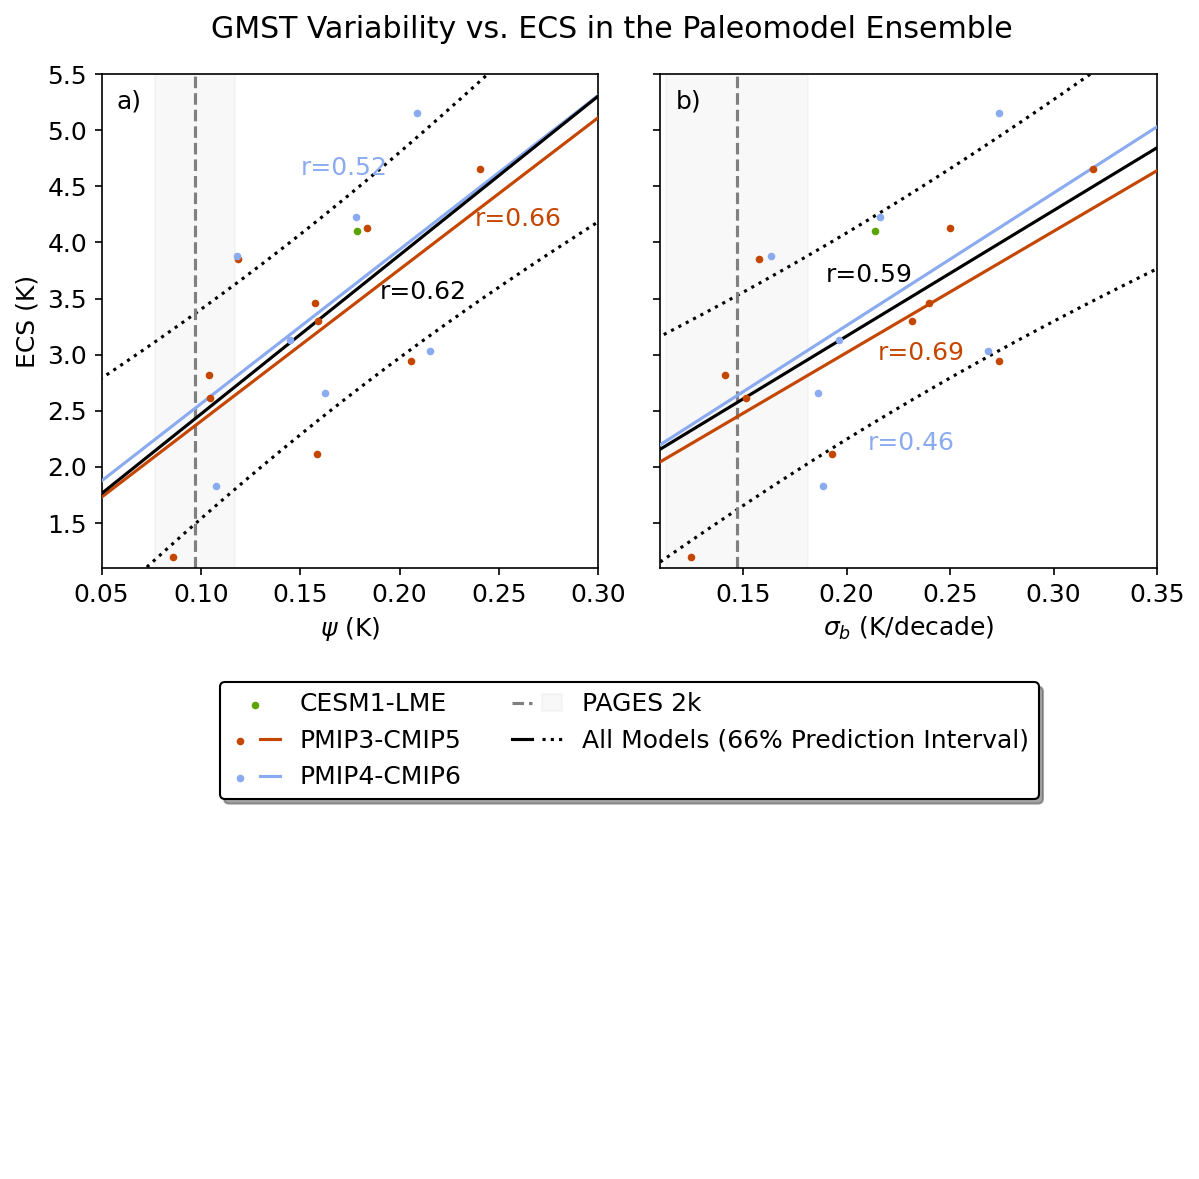

In [5]:
df = pd.read_csv(data_dir/'ec_data.csv').drop('Unnamed: 0', axis=1)

other_color = '#5BA300'
cmip5_color = '#C44601'
cmip6_color = '#8BABF1'
marker_size = 7

cox_all = df['rv_cox']
cox_other = df['rv_cox'][(df['generation']=='na') | (df['generation'] == 'CMIP3')]
cox_cmip5 = df['rv_cox'][df['generation']=='CMIP5']
cox_cmip6 = df['rv_cox'][df['generation']=='CMIP6']

nijsse_all = df['rv_nijsse']
nijsse_other = df['rv_nijsse'][(df['generation']=='na') | (df['generation'] == 'CMIP3')]
nijsse_cmip5 = df['rv_nijsse'][df['generation']=='CMIP5']
nijsse_cmip6 = df['rv_nijsse'][df['generation']=='CMIP6']

ecs_all = df['ecs']
ecs_other = df['ecs'][(df['generation']=='na') | (df['generation'] == 'CMIP3')]
ecs_cmip5 = df['ecs'][df['generation']=='CMIP5']
ecs_cmip6 = df['ecs'][df['generation']=='CMIP6']

fig, axs = plt.subplot_mosaic([[0, 1], [2, 2]],
                              layout='constrained', figsize = (8, 8), sharey=True)

plot_1 = axs[0].scatter(cox_other, ecs_other, color = other_color, s = marker_size, zorder=10)
plot_2 = axs[0].scatter(cox_cmip5, ecs_cmip5, color = cmip5_color, s = marker_size, zorder=10)
plot_3 = axs[0].scatter(cox_cmip6, ecs_cmip6, color = cmip6_color, s = marker_size, zorder=10)
axs[1].scatter(nijsse_other, ecs_other, label = 'other', color = other_color, s = marker_size, zorder=10)
axs[1].scatter(nijsse_cmip5, ecs_cmip5, label = 'CMIP5', color = cmip5_color, s = marker_size, zorder=10)
axs[1].scatter(nijsse_cmip6, ecs_cmip6, label = 'CMIP6', color = cmip6_color, s = marker_size, zorder=10)

axs[0].set_ylabel('ECS (K)')
axs[0].set_xlabel(r'$\psi$ (K)')
axs[1].set_xlabel(r'$\sigma_{b}$ (K/decade)')
axs[0].set_xlim((0.05,0.3))
axs[0].set_ylim((1.1,5.5))
axs[1].set_ylim((1.1,5.5))
axs[1].set_xlim((0.11,0.35))

# linear regression components
x = np.linspace(0, 1, 100)
slope, intercept, r, p, se = linregress(cox_cmip5, ecs_cmip5)
r_cmip5_psi = r

trend_2, = axs[0].plot(x, slope*x + intercept, color = cmip5_color, zorder=4)
slope, intercept, r, p, se = linregress(cox_cmip6, ecs_cmip6)
r_cmip6_psi = r

trend_3, = axs[0].plot(x, slope*x + intercept, color = cmip6_color, zorder=5)
slope, intercept, r, p, se = linregress(nijsse_cmip5, ecs_cmip5)
r_cmip5_sigma = r

axs[1].plot(x, slope*x + intercept, color = cmip5_color, zorder=4)
slope, intercept, r, p, se = linregress(nijsse_cmip6, ecs_cmip6)
r_cmip6_sigma = r

axs[1].plot(x, slope*x + intercept, color = cmip6_color, zorder=5)
slope, intercept, r, p, se = linregress(cox_all, ecs_all)
r_all_psi = r
print('Cox:',intercept, slope, r, np.mean(cox_all), np.std(cox_all), np.mean(ecs_all), np.std(ecs_all))

trend_5, = axs[0].plot(x, slope*x + intercept, color = 'black', zorder=6)
slope, intercept, r, p, se = linregress(nijsse_all, ecs_all)
r_all_sigma = r
print('Nijsse:',intercept, slope, r, np.mean(nijsse_all), np.std(nijsse_all), np.mean(ecs_all), np.std(ecs_all))

axs[1].plot(x, slope*x + intercept, color = 'black', zorder=6)
trend_4 = axs[0].axvline(x = 0.097021844, color = 'gray', linestyle = '--')
shade_4 = axs[0].axvspan(0.097021844-0.020184056, 0.097021844+0.020184056, color = 'gray', alpha = 0.05)

axs[1].axvline(x = 0.146868118, color = 'gray', linestyle = '--', zorder=0)
axs[1].axvspan(0.146868118-0.034300603, 0.146868118+0.034300603, color = 'gray', alpha = 0.05, zorder=0)

# add in the r values
axs[0].text(x = 0.15, y = 4.6, s = 'r='+str(np.round(r_cmip6_psi,2)), color = cmip6_color)
axs[0].text(x = 0.238, y = 4.15, s = 'r='+str(np.round(r_cmip5_psi,2)), color = cmip5_color)
axs[0].text(x = 0.19, y = 3.5, s = 'r='+str(np.round(r_all_psi,2)), color = 'black')

axs[1].text(x = 0.21, y = 2.15, s = 'r='+str(np.round(r_cmip6_sigma,2)), color = cmip6_color)
axs[1].text(x = 0.19, y = 3.65, s = 'r='+str(np.round(r_all_sigma,2)), color = 'black')
axs[1].text(x = 0.215, y = 2.95, s = 'r='+str(np.round(r_cmip5_sigma,2)), color = cmip5_color)

# prediction intervals
def equation(a, b):
    """Return a 1D polynomial."""
    return np.polyval(a, b) 

x = cox_all
y = ecs_all

p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
n = 16                                           # number of observations
m = p.size    
dof = n - m                                                # degrees of freedom
t = stats.t.ppf(0.83, n - m)                              # t-statistic; used for CI and PI bands
y_model = equation(p, x)  

# Estimates of Error in Data/Model
resid = y - y_model                                        # residuals; diff. actual data from predicted values
chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error

x2 = np.linspace(0, 1, 100)
y2 = equation(p, x2)

pi = t * s_err * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   
axs[0].fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
axs[0].plot(x2, y2 - pi, linestyle='dotted', color="black", label="66% Prediction Limits", zorder=-1)
axs[0].plot(x2, y2 + pi, linestyle='dotted', color="black", zorder=-1)

x = nijsse_all
y = ecs_all

p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
n = 16                                           # number of observations
m = p.size    
dof = n - m                                                # degrees of freedom
t = stats.t.ppf(0.83, n - m)                              # t-statistic; used for CI and PI bands
y_model = equation(p, x)  

# Estimates of Error in Data/Model
resid = y - y_model                                        # residuals; diff. actual data from predicted values
chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error

x2 = np.linspace(0, 1, 100)
y2 = equation(p, x2)

pi = t * s_err * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   
axs[1].fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
trend_6, = axs[1].plot(x2, y2 - pi, linestyle='dotted', zorder=-1, color="black", label="66% Prediction Limits")
axs[1].plot(x2, y2 + pi, linestyle='dotted', zorder=-1, color="black")

fig.suptitle('GMST Variability vs. ECS in the Paleomodel Ensemble')

axs[0].annotate(xy=(0.03,0.93), text='a)', xycoords='axes fraction')
axs[1].annotate(xy=(0.03,0.93), text='b)', xycoords='axes fraction')

axs[2].legend([plot_1, (plot_2, trend_2), (plot_3, trend_3), (trend_4, shade_4), (trend_5, trend_6)], ['CESM1-LME', 'PMIP3-CMIP5', 'PMIP4-CMIP6', 'PAGES 2k', 'All Models (66% Prediction Interval)'],
              handler_map = {tuple : HandlerTuple(None)}, framealpha=1, edgecolor='black', loc = 'upper center', shadow=True, ncol=2)

plt.axis('off')
plt.tight_layout()  
# plt.savefig('figures/figure_3.png', dpi=3000, facecolor='w', bbox_inches='tight')